# A statistical analysis of droplets generated in ensembles of randomly corrugated ligaments

We study the statistical description of droplet sizes, created as a result
of capillary-induced breakup of ligaments. **Direct numerical simulations** of *air-water systems*
are employed by solving the two-phase Navier-Stokes equations on adaptive Octree grids
[Basilisk](http://basilisk.fr/), using the VOF methodology coupled with height function based
curvature modeling. Breakup of individual ligaments are triggered by initial surface
corrugations, the dynamics of which are deterministic. **Stochasticity** is introduced in the mix
by conducting an *ensemble of simulations* of slender corrugated ligaments, each realization
corresponding to a **random but unique initial configuration**. Probability density functions of
the droplet sizes are computed for different ensemble sizes. Thus, by combining
the effects of stochasticity with the capillarity-driven non-linear dynamics, we can improve our understanding of the nature of drop size distributions encountered in realistic
and convoluted fluid fragmentation scenarios.

> #### TL;DR 
> - corrugated water ligaments in air (~ 100,000's) 
> - ligaments breakup due to complicated effects 
> - ensembles of drops generated (~1000,000's) 
> - probability distributions of drops?   


## Problem Setup 
We have an air-water configuration, thus for the given material properties the length scale of our problem is governed by 

$$ \textrm{Oh}= \frac{\mu}{\sqrt{\rho \sigma R}} \quad , \quad \Lambda = L/W \,.$$
> The reference density and viscosity correspond to the liquid. 

As we do not incorporate any axial stretching rate or initial velocity distribution inside the ligament, our setup can be understood to be at the limit of $\textrm{We} \to 1$ . 

### Computational Domain
The ligament is placed in a square domain of size $L$, with a mean radius $R$. The radial profile along the axial direction is given by 

$$ R(x) = R + \epsilon(x) \quad , \, \text{where} \quad  \epsilon \sim \mathcal{N}(0,\lambda^2) $$

The schematic of the computational setup is shown below -

<img src="./schematic.png" style="width: 500px;" align="center" />

### Surface generation
We deal with slender ligaments (i.e. length >> diameter), and we impose periodicity along the axial direction. The surface (radial profile) of this axisymmetric ligament is generated by superposing waves of different wavelenghts, the amplitudes of which are **normally distributed**. This newly generated surface is passed through a **low-pass filter**, which allows us to smoothen the profile and circumvent the extremely sharp peaks/kinks on the surface (our solvers don't like discontinuous derivatives). An example of the surface generation and subsequent filtering is shown below -

<img src="./profile.png" style="width: 600px;" align="center"/>


Thus, we can clearly see that by filtering out all but the $n_c$ longest discrete waves, the final shape of the ligament can be characterized by 

$$ K = n_c \cdot (2\pi W/L) \quad , \quad \varepsilon = \lambda / R \,. $$

> $\lambda_0$ corresponds to standard deviation of the normal distribution used to generate the initial un-filtered surface, while $\lambda$ corresponds to the shape obtained passing it through the low-pass filter. 

#### Energy supplied to discrete modes 
Contrary to the continuous problem, in our numerical simulations we can only inject energy into a **discrete** set of wavenumbers, as demonstrated below using the dispersion relation for the canonical Rayleigh-Plateau instability. 

<img src="waves.png" style="width: 600px;" align="center" />

Thus, the total number of wavenumbers perturbed in the unstable part of the spectrum is 

$$ \Delta k = \Lambda/\pi - 1 $$

Thus, instead of the infinite number of continuous wavenumbers in the unstable part of the spectrum interacting amongst themselves, we get only a handful of them in our discrete setup. At a later part of the analysis, we will see if this any meaningful impact on the size distributions of the drops formed.

### Destabilization of an individual ligament

Let us rescale our physical time $t$ using the capillary timescale at the length scale $R$ of the ligaments. Thus, our time variable is now given by 

$$ T = t \cdot \left(\rho R^3 / \sigma \right)^{-1/2} $$

As an example, we choose a millimeter scale ligament, whose surface is *weakly perturbed*. It should be noted that **all** of the individual ligaments in this particular **ensemble** are characterized by $\Phi$, which is defined as 

$$ \Phi = \left(\textrm{Oh} = 10^{-2}, \varepsilon \approx 0.04 , K = 2\pi , \Lambda = 50 \right) \,.$$

> $\Phi$ acts as a point in the parameter space of all possible corrugated ligament configurations. 

The shape of the ligament initially evolves as per the exponential growth phase well described by linear perturbation theory. Once the perturbations attain a certain amplitude, the non-linear growth kicks in, given by the energy tranfers between different frequencies. The animation below shows the temporal evolution of the ligament, which eventually breaks up into drops, which themselves might undergo coalescence with neighbouring drops. 

![animation](./ligament_breakup.gif)

The colormap on the top half represents the axial velocity, whereas the bottom half corresponds to vorticity. 

## Exploratory Data Analysis 

We have datasets corresponding to variation in the following parameters of the ligament ensemble
- Strongly perturbed and weakly perturbed : $\varepsilon = \{0.038, 0.076\}$
- Smaller and larger aspect ratios : $\Lambda = \{50,100\}$

We start by loading the required libraries, and set the plotting styles. 

In [1]:
# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']


#sns.set(style="white", palette="muted")
#sns.set_context("paper")


All of the datasets are concatenated onto a single, structured, ASCII format data file. 

In [2]:
drops = pd.read_csv("results", sep=" ")

This is how the dataset looks ! 

In [3]:
drops.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


What is the total size of the dataset ? 

In [4]:
drops.shape

(3653802, 13)

We have approximately 3.6 millions data points after combining the 4 datasets. Let us create separate copies of the 4 distinct datasets which are mixed in the original one. 

In [5]:
# low amplitude , low aspect
d1 = drops.loc[(drops.amplitude == 0.1) & (drops['aspect-ratio'] == 50)]

# low amplitude , large aspect
d2 = drops.loc[(drops.amplitude == 0.1) & (drops['aspect-ratio'] == 100)]

# large amplitude , low aspect 
d3 = drops.loc[(drops.amplitude == 0.2) & (drops['aspect-ratio'] == 50)]

# large amplitude , large aspect
d4 = drops.loc[(drops.amplitude == 0.2) & (drops['aspect-ratio'] == 100)]

Let us check if they are correctly sorted. 

In [6]:
d1.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


In [7]:
d2.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
772889,0.01,100,0.25,0.1,0,1,98.9443,0.000000,201.87100,16.03620,2158.17000,200.000,8296
772890,0.01,100,0.25,0.1,6,1,98.7653,-0.000011,210.79200,16.38670,2302.80000,200.000,740
772891,0.01,100,0.25,0.1,12,1,98.9456,0.000172,208.46600,16.29610,2264.78000,200.000,1254
772892,0.01,100,0.25,0.1,18,1,98.8410,0.000161,207.25700,16.24870,2245.11000,200.000,2354
772893,0.01,100,0.25,0.1,24,1,197.4140,0.013180,5.60521,2.67215,9.98533,-186.751,90


In [8]:
d3.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
1680726,0.01,50,0.5,0.2,0,1,48.9594,0.000000,101.725000,11.383600,771.997000,100.00000,7758
1680727,0.01,50,0.5,0.2,6,1,48.9057,-0.000527,103.445000,11.479400,791.660000,100.00000,1397
1680728,0.01,50,0.5,0.2,12,14,84.3172,0.002377,30.222700,6.204860,125.019000,69.86240,701
1680729,0.01,50,0.5,0.2,12,13,70.8915,2.326830,0.243942,0.557453,0.090658,13.42570,66
1680730,0.01,50,0.5,0.2,12,12,64.4259,0.084844,8.234140,3.238730,17.778700,6.46556,191


In [9]:
d4.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
2580588,0.01,100,0.25,0.2,0,1,97.9285,0.000000,203.68700,16.10820,2187.36000,200.0000,7837
2580589,0.01,100,0.25,0.2,6,1,97.9144,-0.000042,211.31300,16.40700,2311.34000,200.0000,799
2580590,0.01,100,0.25,0.2,12,1,97.6819,-0.000663,209.08300,16.32010,2274.84000,200.0000,1971
2580591,0.01,100,0.25,0.2,18,12,166.1750,0.026505,62.36370,8.91315,370.57200,150.4680,813
2580592,0.01,100,0.25,0.2,18,11,119.5590,0.304221,3.75126,2.18602,5.46688,46.6159,129


### Small amplitude - Small aspect-ratio

Let us plot the drop size distributions at various instants of time T. We start with the first dataset `d1`. 

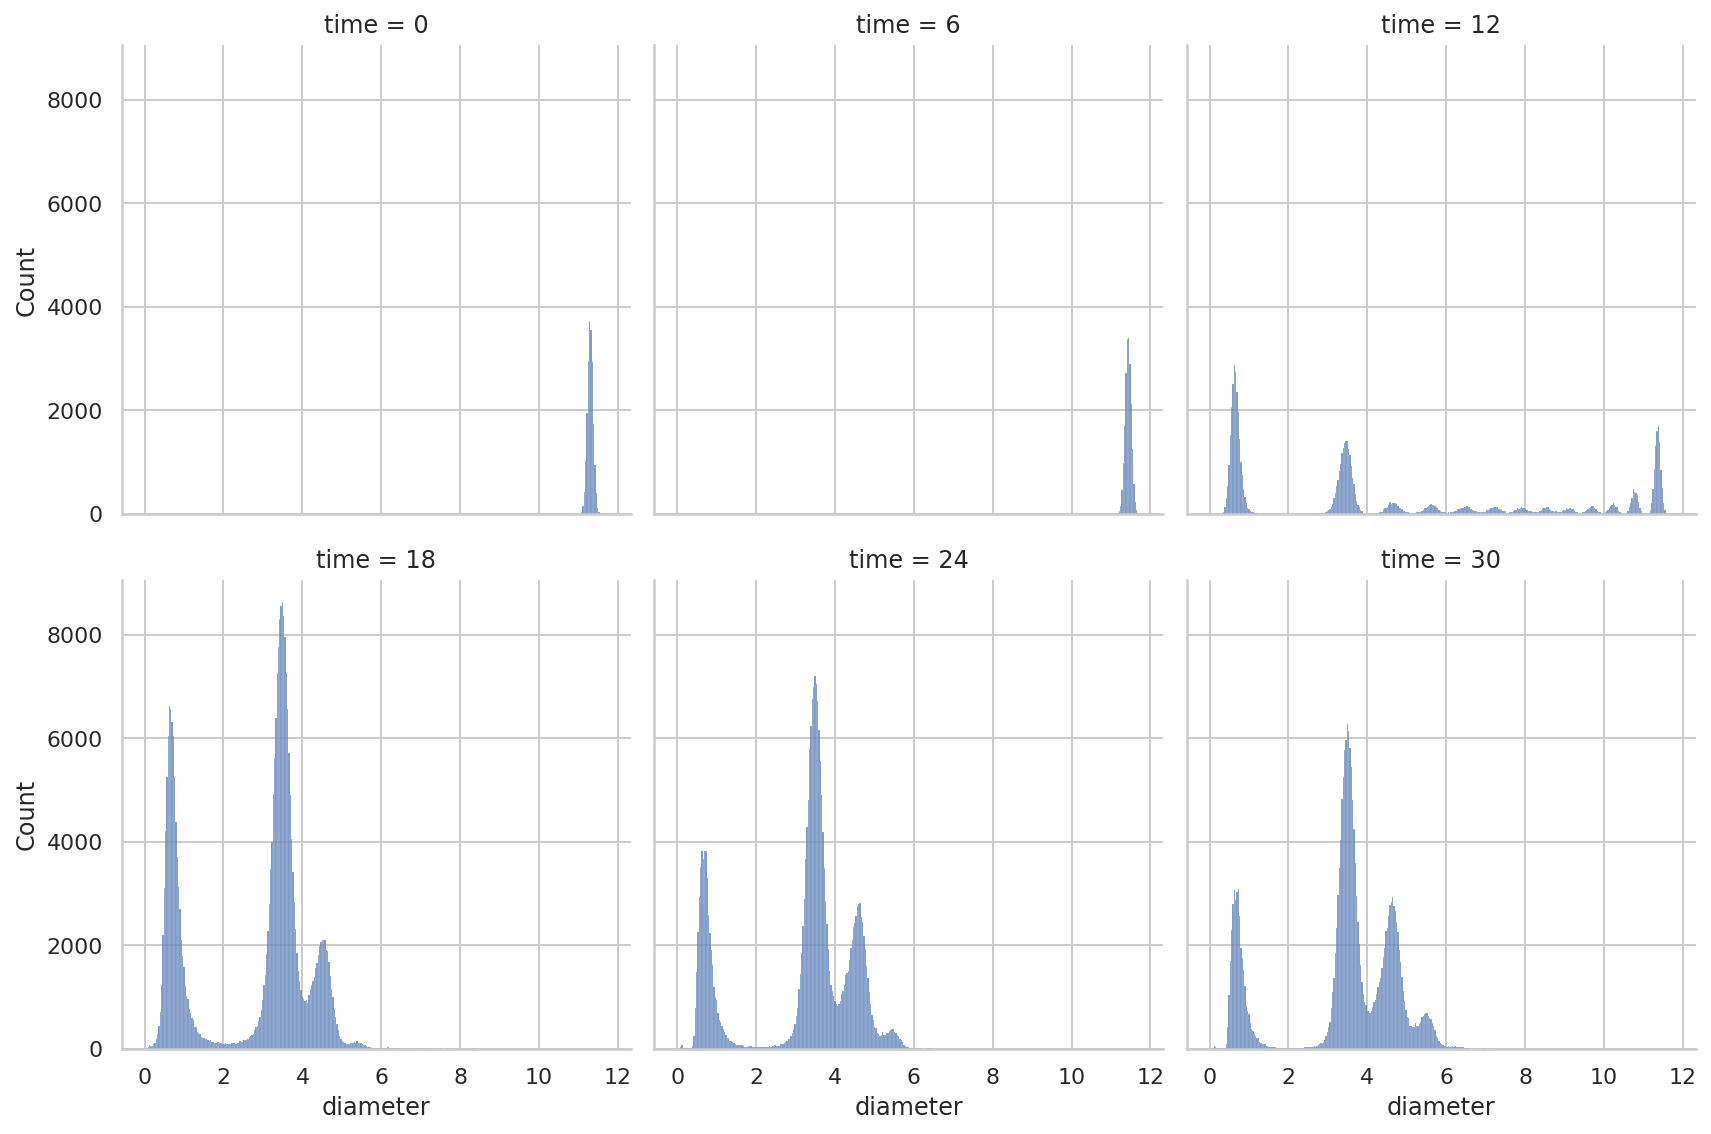

In [10]:
sns.displot(data=d1, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3) ; 


### Small amplitude - Large aspect-ratio
Now we plot the same for dataset `d2`, which has the same strength of initial perturbation as `d1`, but the ligaments are twice as long. Thus, more number of discrete modes are added to the unstable part of the canonical Rayleigh-Plateau dispersion relation.

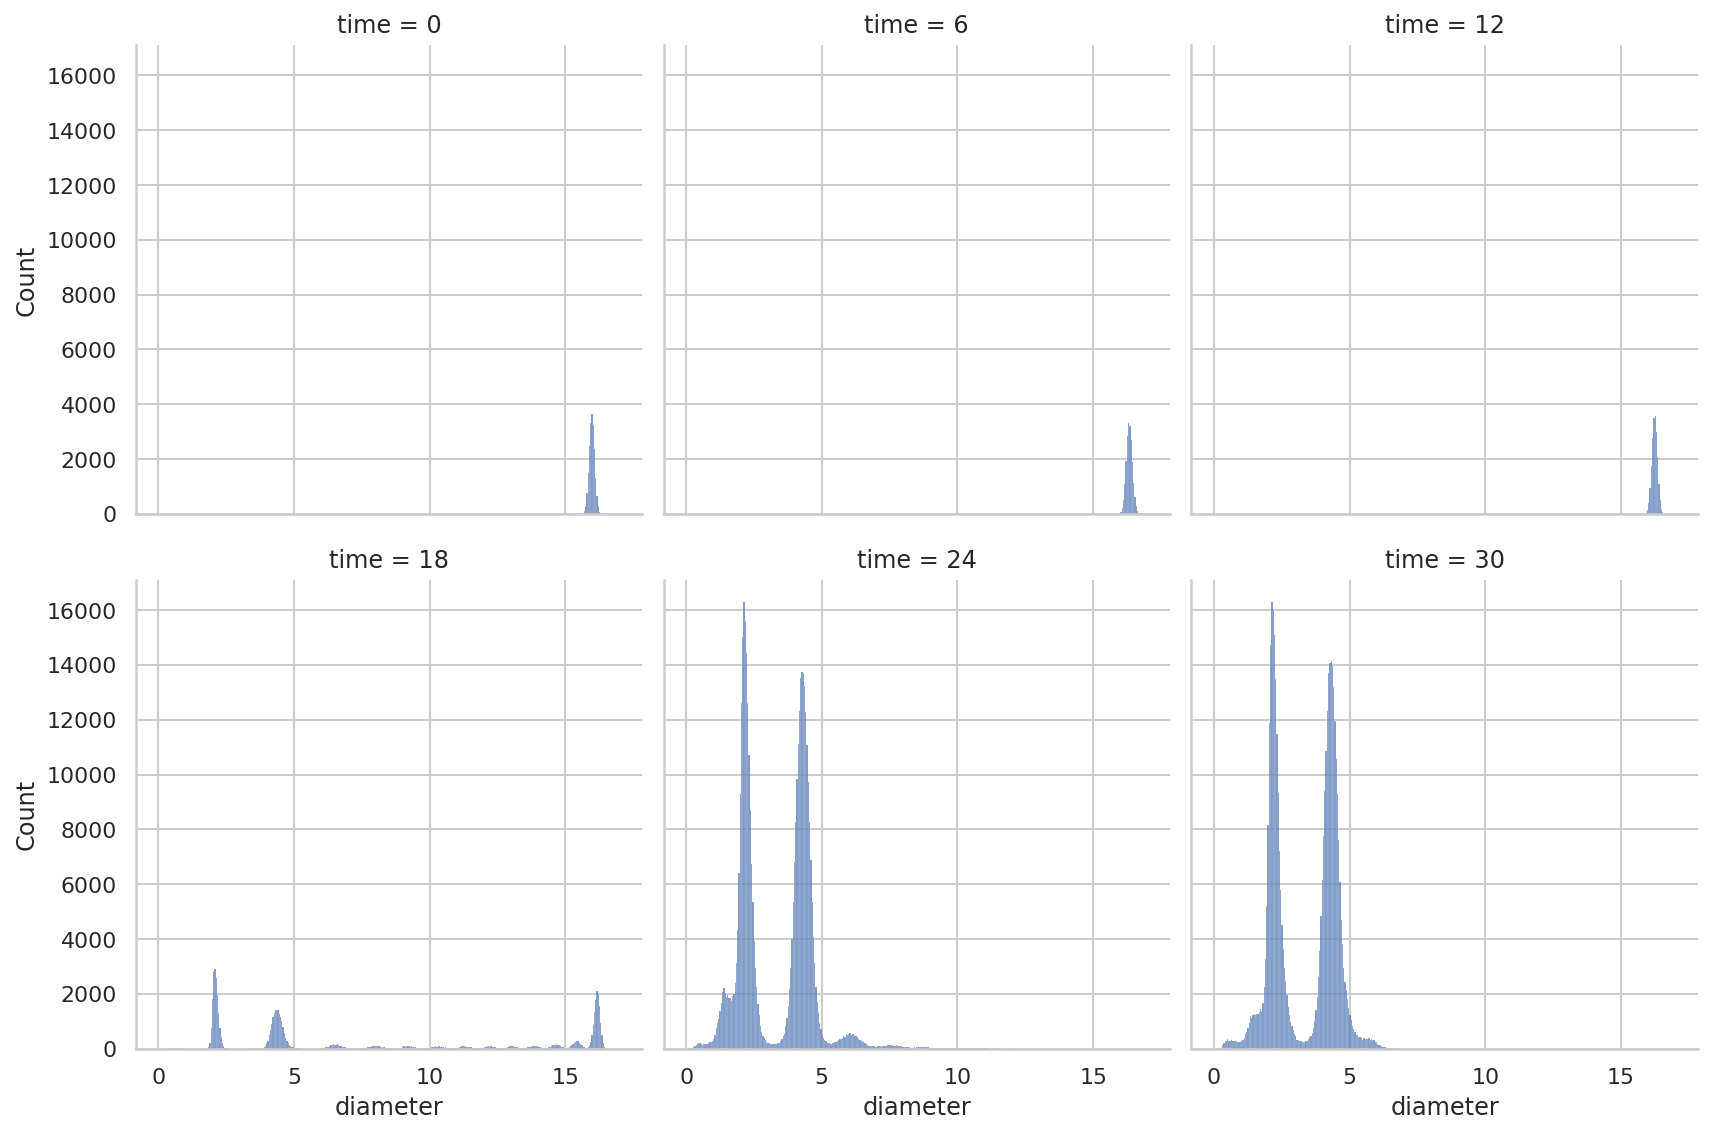

In [11]:
sns.displot(data=d2, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3) ; 


### Large amplitude - Small aspect-ratio

We repeat this for dataset `d3`, getting the plots below - 

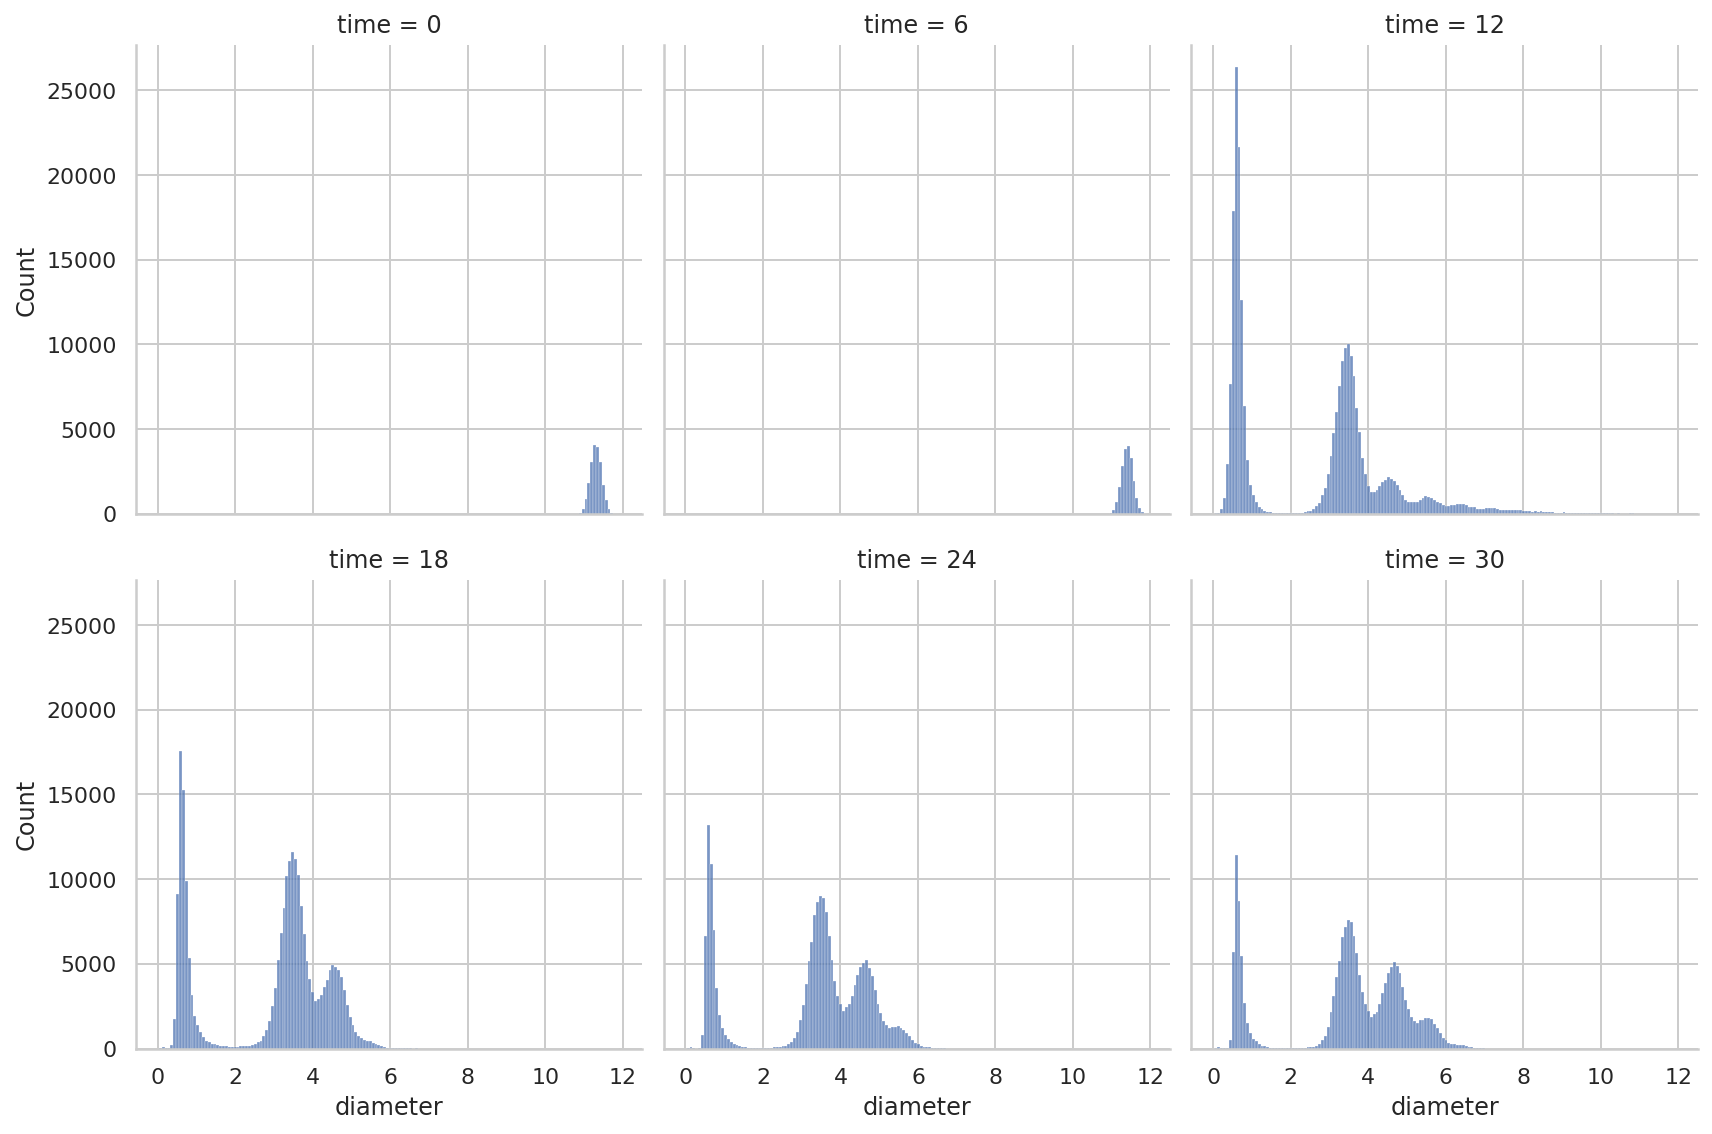

In [12]:
sns.displot(data=d3, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3) ; 

### Large amplitude - Large aspect-ratio

And finally for dataset `d4`. 

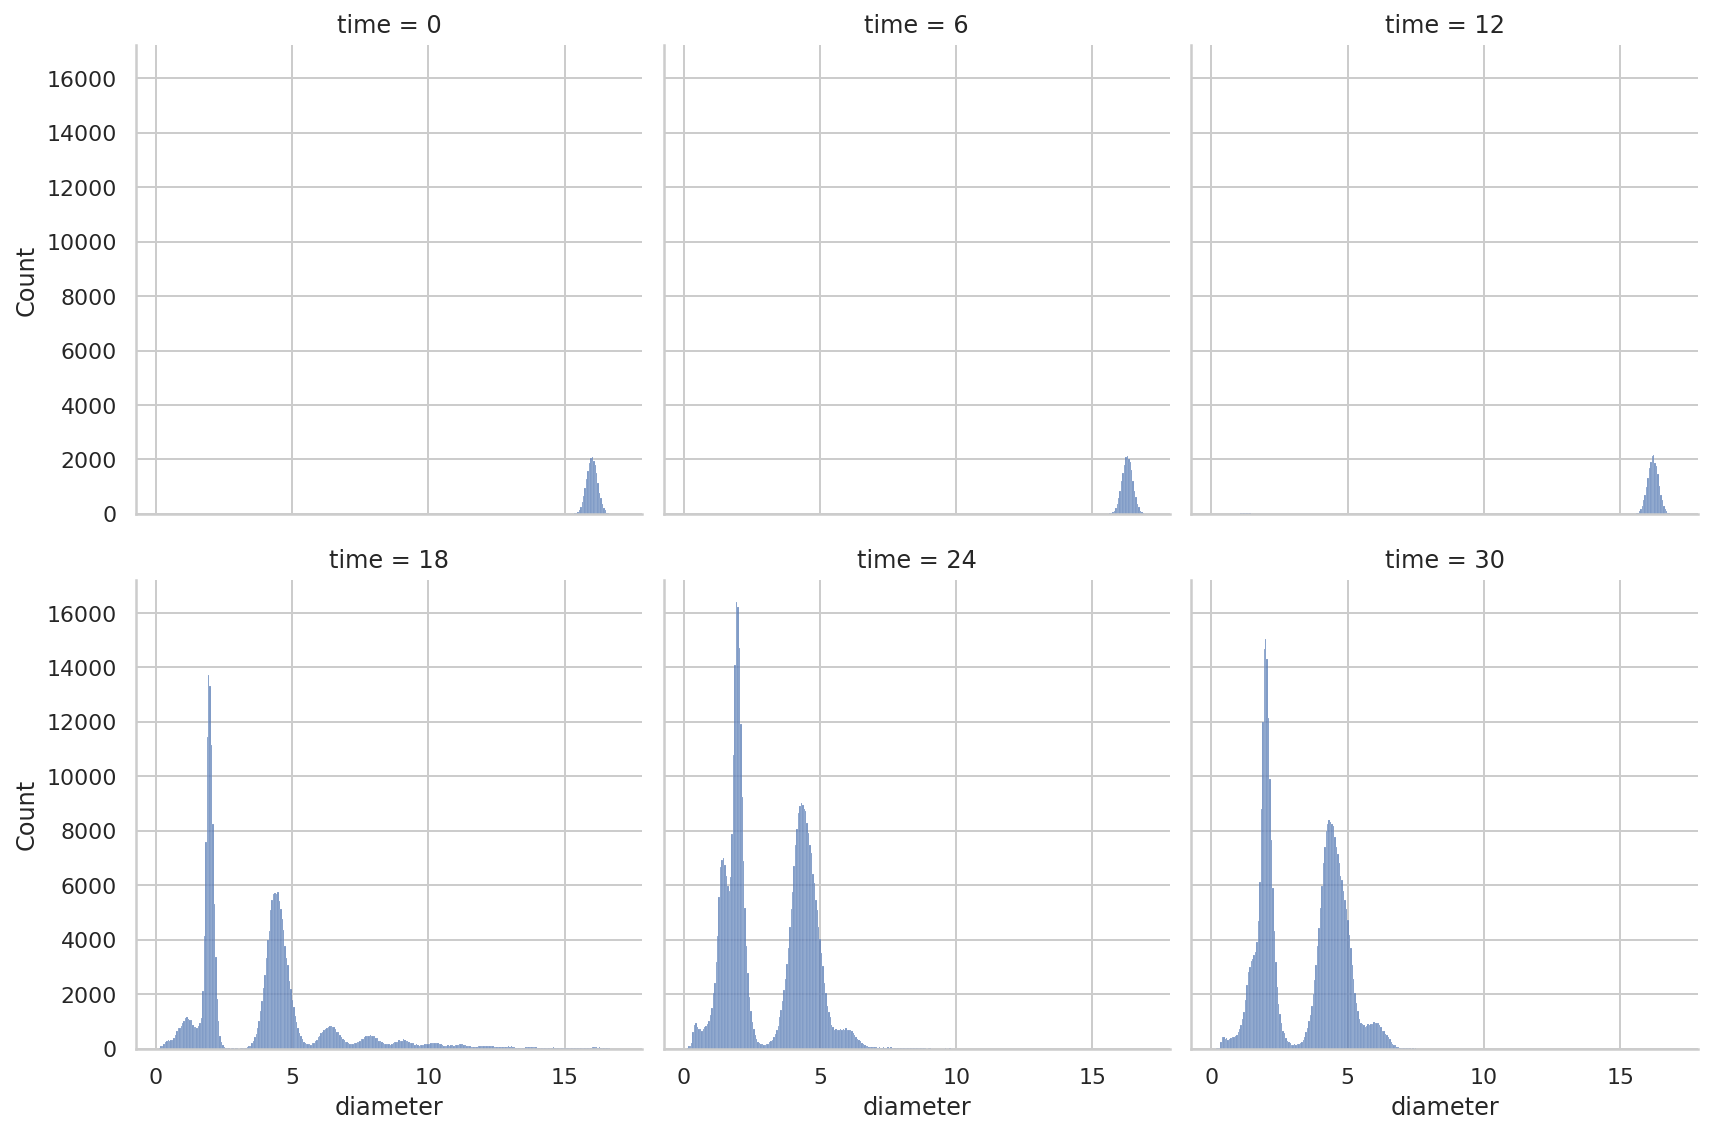

In [13]:
sns.displot(data=d4, kind="hist", kde=False, x="diameter", col="time", 
            legend=True, palette="bright", height=4.0, aspect=1.0, col_wrap=3) ; 

We observe that the distributions before T=18 are not very interesting, because the ligament still has not broken down into the drops. Let us concentrate on T=18.

### Verification of quantization effects


#### Volume based estimation ?? 
Let us compute the values for the **equivalent diameters**, which can be simply estimated by equating the volume under our *discrete* wavelengths ($L_i $) to the volume of a drop with diameter $D_i$. Thus we get 

$$ \pi D_i^3 /6 = \pi R^2 L_i \implies D_i = (6 L_i R^2 )^{1/3} $$ 

The $i$ in the above equation refers to the discrete wave number, whose wavelength is given by $L_i = L/i$. We also rescale the the diameters with the intial width of the ligament $W$, thus giving us 

$$ D_i / W = \left(3\Lambda /2i \right)^{1/3} \,. $$

---

#### Area based estimation

But, in our computational setup, the droplet diameters are computed using areas, not volumes (3D axisymmetric simulations). Thus, it makes more sense to compute them from the areas, which gives us 

$$ \pi D_i^2 / 4 = 2 R L_i \quad \implies D_i/W = \left(4\Lambda /\pi i \right)^{1/2} \,.  $$

We observe that the prefactors are approximately the same, $3/2$ and $4/\pi$ for the volume and area based estimations respectively. Therefore, the volume based estimate gives significantly smaller estimates ($\Lambda^{1/3}$ vs. $\Lambda^{1/2}$). 


Now, setting $i=1$, we get the maximum possible equivalent diameter, which is the case if the entire ligament collapsed into a single drop. 

> **We select the area based estimate as the volume based one gives us a massive underestimation for the maximum size of the drop that can form, as in reality, we get many drops which are larger than this estimate.**


The shortest wavelength which is unstable with respect to Rayleigh-Plateau is given by 

$$ i \approx \Lambda/\pi \quad \implies D_\textrm{short}/W \approx 2.0 $$

For the optimal (largest growth rate) wavelength of the Rayleigh-Plateau instability, we have 

$$ i \approx 0.7 \Lambda/\pi \quad \implies D_\textrm{rp}/W \approx 2.39 $$

> $\Lambda = 50$ for `d1` and `d3` datasets, and $100$ for `d2` and `d4`. 

Therefore, we have several interesting values for the equivalent diameters as follows 
- $D_\textrm{max}/W \approx \{7.98,11.28\}$ : Largest wavelength for the $\Lambda =50$ and $\Lambda =100$ cases respectively (entire ligament) .
- $D_\textrm{rp}/W \approx 2.39$ : Wavelength corresponding to optimal growth rate of Rayleigh-Plateau instability.
- $D_\textrm{short}/ W \approx 2.0$ : Shortest unstable wavelength for Rayleigh-Plateau instability.
- $D_\textrm{cut}/W \approx \{1.12,1.60\} $: Cut-off wavelengths set by low-pass filter, for the $\Lambda =50$ and $\Lambda =100$ cases respectively . 

> Refer to the Rayleigh-Plateau dispersion relation plot in the at the start of this notebook, in order to compute the above values. 

--- 

Let us assign these values to some variables. 

In [14]:
#initializing values for analysis of d1,d3 datasets

d_max_1 = 7.89 # aspect-ratio = 50
d_max_2 = 11.28 # aspect-ratio = 100
d_rp = 1.89
d_sh = 1.68
d_cut_1 = 1.12 # aspect-ratio = 50
d_cut_2 = 1.60 # aspect-ratio = 100

We start with the first dataset `d1`, and plot the critical values of **equivalent diameters**, at a time slice T=18. The time slices before T=18 are not interesting as the ligaments are yet to rupture completely.  

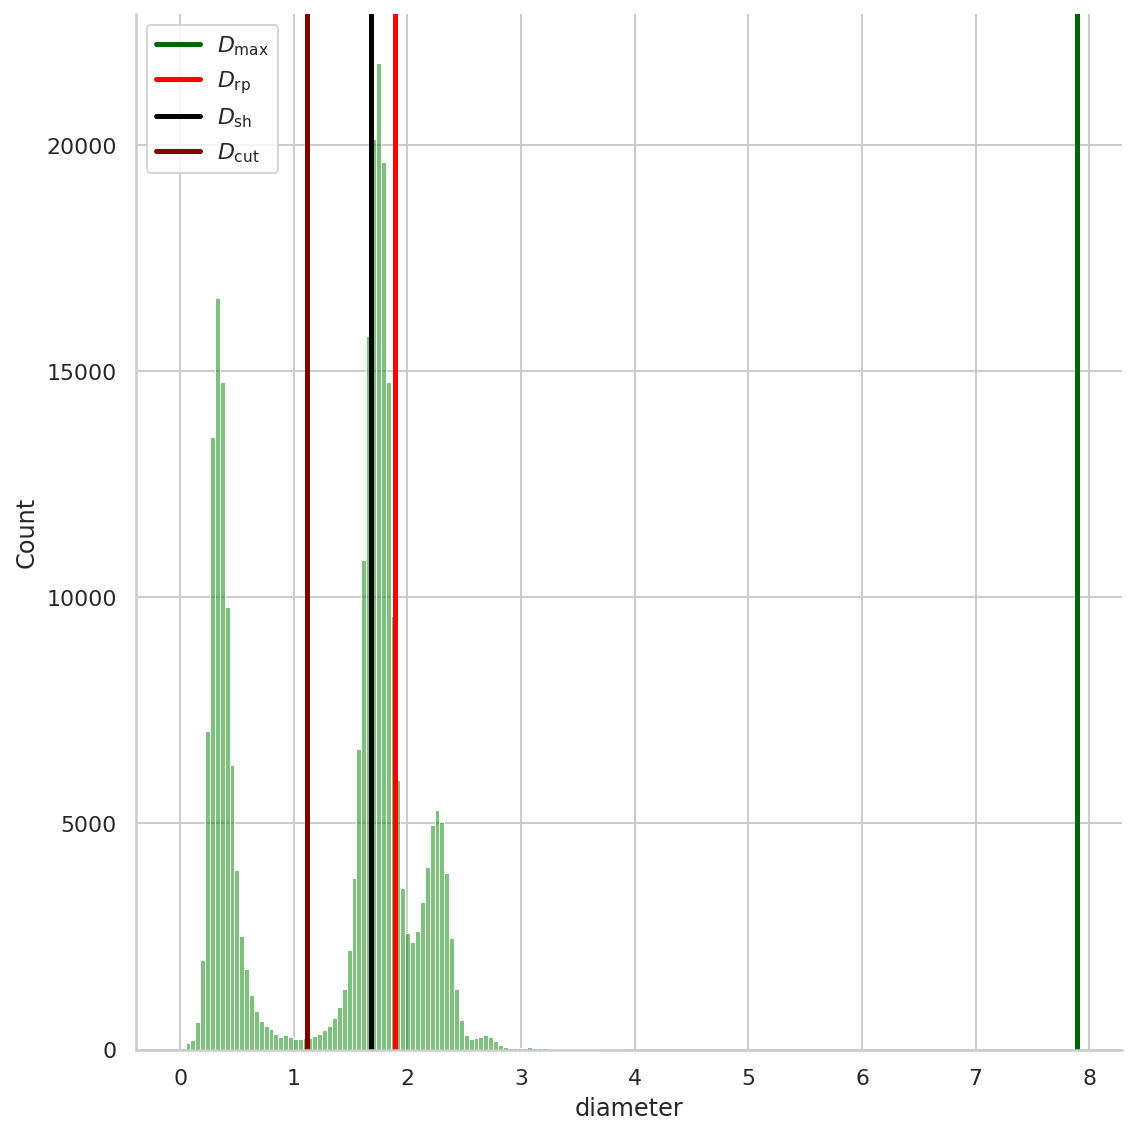

In [15]:
# histogram for d1
sns.displot(data=d1.diameter[(d1.time == 18)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=8.0, aspect=1.0,
           alpha = 0.5 , color = 'green') ;

# plotting the vertical lines for d_max, d_rp, d_sh, d_cut 
plt.axvline(x = d_max_1, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}$', color='black', lw=2.5);
plt.axvline(x = d_cut_1, label = r'$D_{\rm{cut}}$', color='maroon', lw=2.5);
plt.legend();

Plotting using the Y axis on log scale, along with the diameters corresponding to all 50 initial discrete modes , we get - 

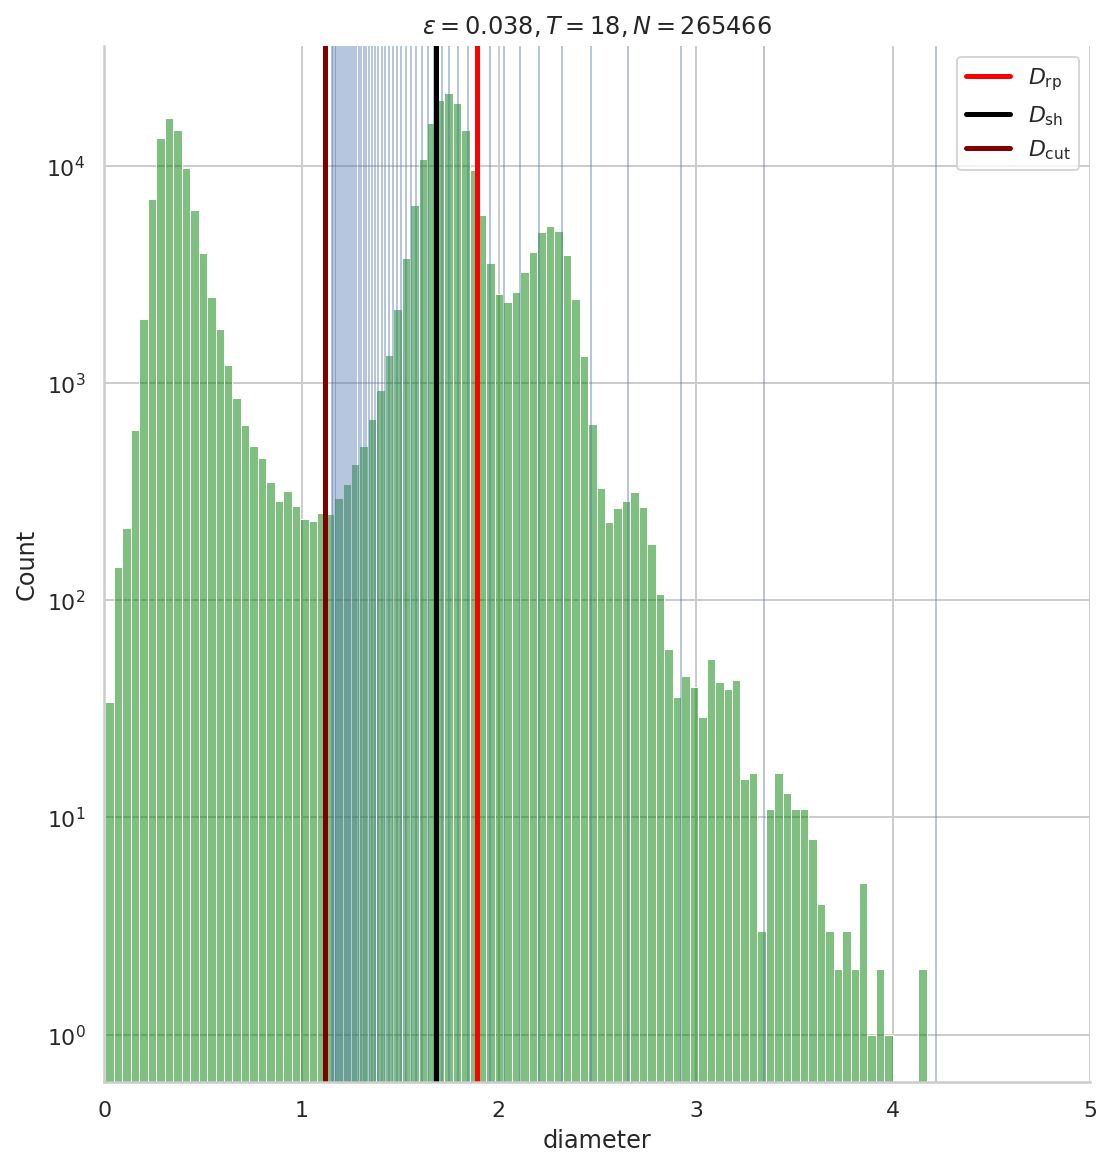

In [20]:
sns.displot(data=d1.diameter[(d1.time == 18)].map(lambda p: p/2.0), kind="hist", kde=False,
            legend=True, palette="bright", height=8.0, aspect=1.0,
           alpha = 0.5 , color = 'green') ;

def d_eq(i, lam):
    a = ((1.5*lam)/i)**(1.0/3.0)
    return a 


# Plotting all of the equivalent diameters (vertical blue lines)
# corresponding to all 50 discrete waves

for i in range(1,50):
    plt.axvline(x = d_eq(i,50.0), lw = 1.0, alpha=0.4);
    
#plt.axvline(x = d_max_1, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}$', color='black', lw=2.5);
plt.axvline(x = d_cut_1, label = r'$D_{\rm{cut}}$', color='maroon', lw=2.5);
plt.xlim(0.0,5.0);
plt.title(r'$\varepsilon = 0.038 , T=18, N=%d$ ' %d1.diameter[d1.time == 18].shape[0]);
plt.legend(loc='best');
plt.yscale("log");

Let us carry out the same exercise, but for the stronger initial perturbation strength. Thus we use dataset `d3` at T=12.

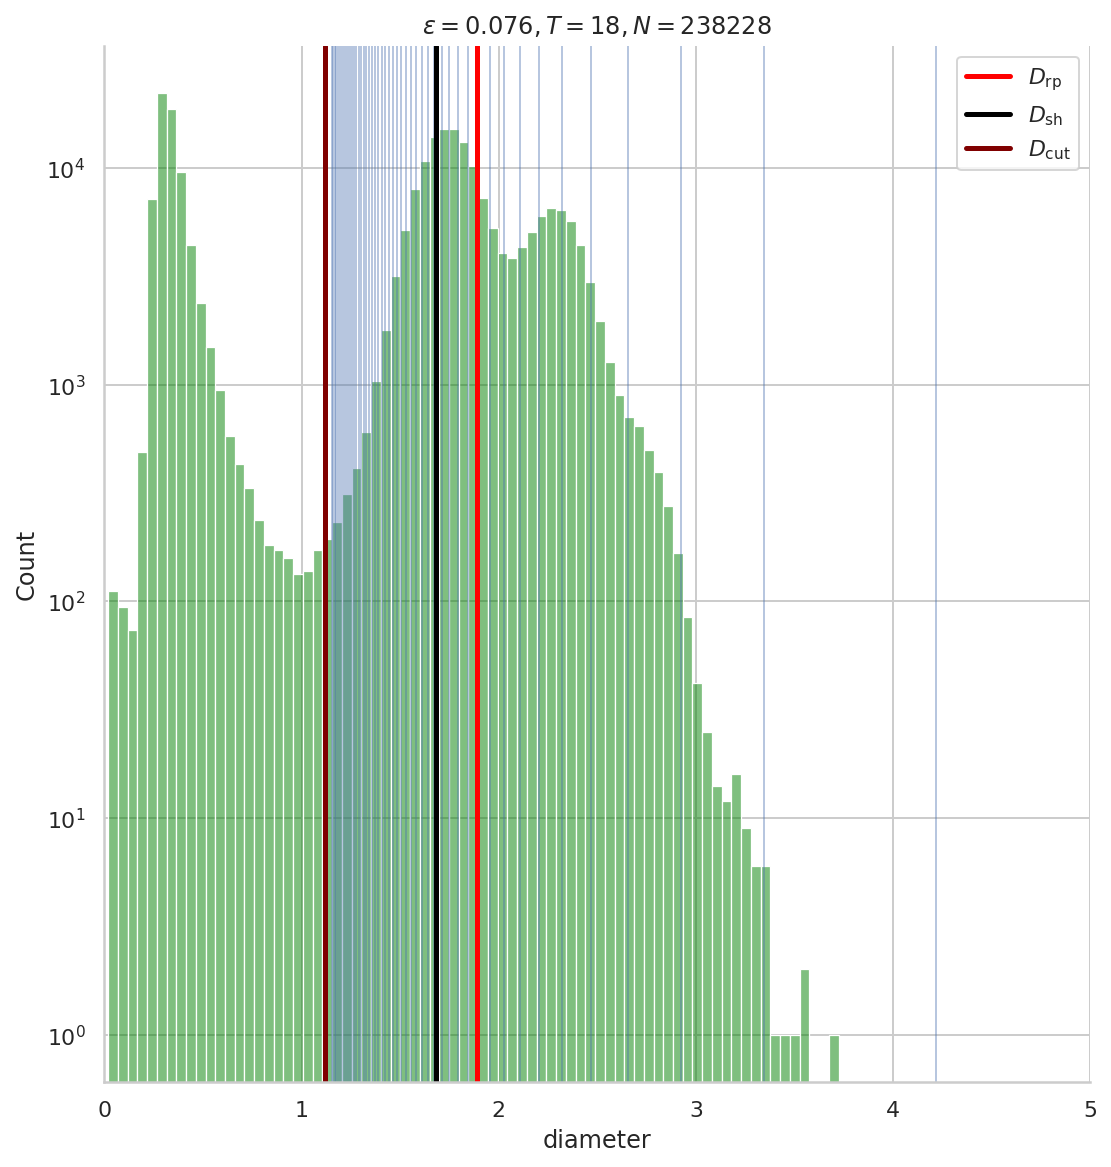

In [22]:
sns.displot(data=d3.diameter[(d3.time == 18)].map(lambda p: p/2.0) 
            , kind="hist", kde=False,
            legend=True, palette="bright", height=8.0, aspect=1.0,
           alpha = 0.5 , color = 'green') ;

for i in range(1,50):
    plt.axvline(x = d_eq(i,50.0), lw = 1.0, alpha=0.4);
    
#plt.axvline(x = d_max, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}$', color='black', lw=2.5);
plt.axvline(x = d_cut_1, label = r'$D_{\rm{cut}}$', color='maroon', lw=2.5);
plt.xlim(0.0,5.0);
plt.title(r'$\varepsilon = 0.076 , T=18, N=%d$ ' %d3.diameter[d3.time == 18].shape[0]);
plt.legend(loc='best');
plt.yscale("log");


Next, we carry out the same exercise for the larger aspect ratio ligament ensembles. We plot the same histograms for `d2` and `d4` datasets. 

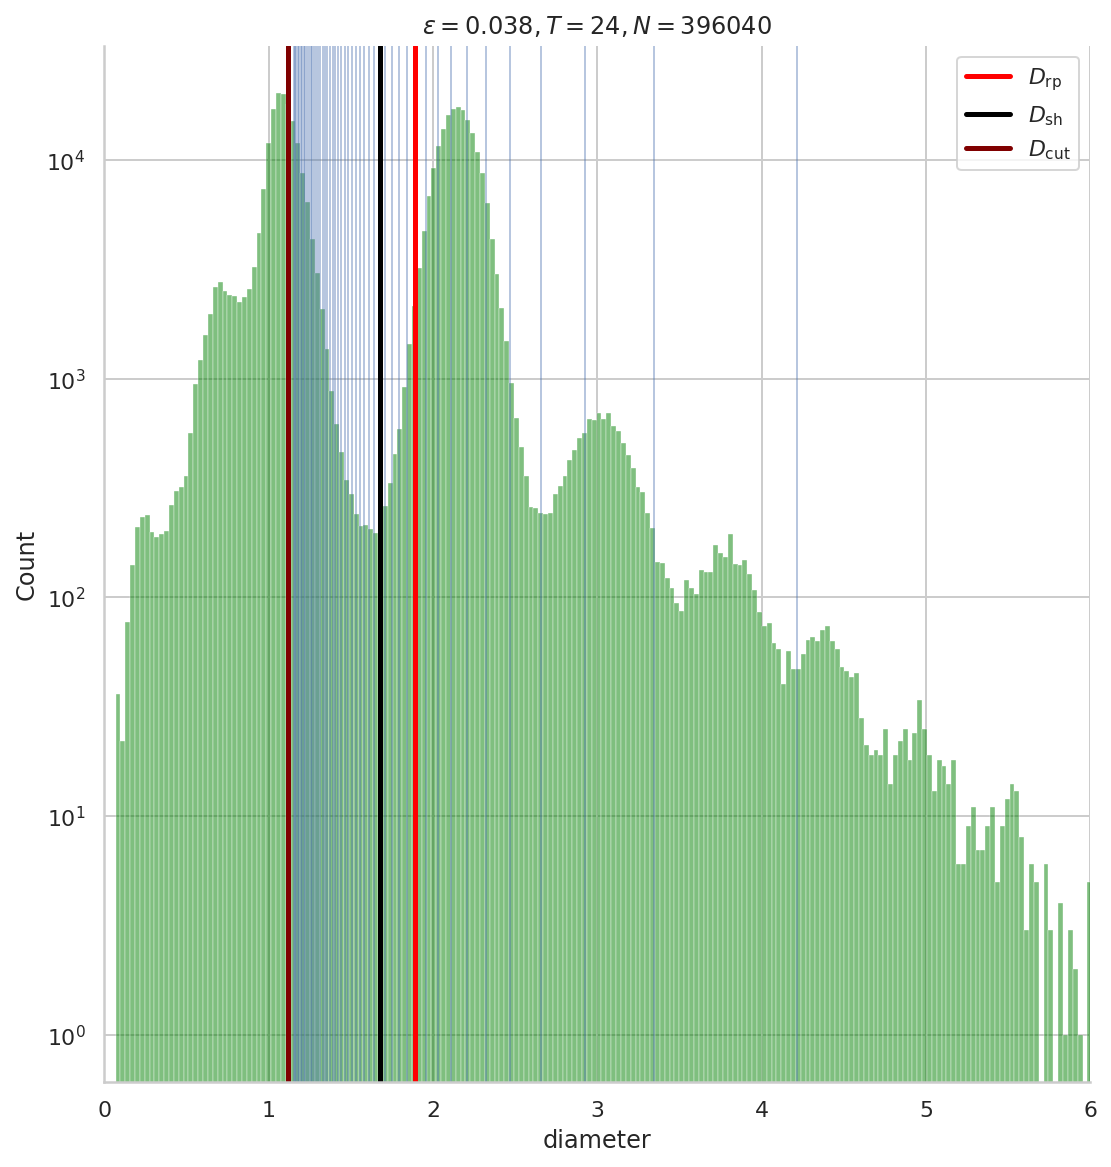

In [24]:
sns.displot(data=d2.diameter[(d2.time == 24)].map(lambda p: p/2.0) 
            , kind="hist", kde=False,
            legend=True, palette="bright", height=8.0, aspect=1.0,
           alpha = 0.5 , color = 'green') ;

for i in range(1,50):
    plt.axvline(x = d_eq(i,50.0), lw = 1.0, alpha=0.4);
    
#plt.axvline(x = d_max, label = r'$D_{\rm{max}}$', color='darkgreen',lw=2.5);
plt.axvline(x = d_rp, label = r'$D_{\rm{rp}}$', color='red', lw=2.5);
plt.axvline(x = d_sh, label = r'$D_{\rm{sh}}$', color='black', lw=2.5);
plt.axvline(x = d_cut_1, label = r'$D_{\rm{cut}}$', color='maroon', lw=2.5);
plt.xlim(0.0,6.0);
plt.title(r'$\varepsilon = 0.038 , T=24, N=%d$ ' %d2.diameter[d2.time == 24].shape[0]);
plt.legend(loc='best');
plt.yscale("log");
